# Spanish Translation A/B Test #

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chisquare

%matplotlib inline
matplotlib.style.use('ggplot')

## Exploratory Data Analysis ##

In [2]:
def cat_col_summary(df, cols):
    for val in cols:
        print('total counts: ', df[val].count())
        print(df[val].value_counts())
        print('-'*40)
        
def df_summary(df, cols):
    print('dim of table:')
    print(df.shape, '\n')
    
    print('first few rows of the table:')
    print('='*40)
    print(df.head(), '\n')
    
    print('count of null values:')
    print('='*40)
    print(df.isnull().sum(), '\n')
    
    print('summary of numeric values')
    print('='*40)
    print(df.describe(), '\n')
    
    print('\nsummary of categorical values')
    print('='*40)
    cat_col_summary(df, cols)

In [3]:
# test activities
test_df = pd.read_csv('test_table.csv')
# discrete_vals = ['source', 'device', 'browser_language', 'ads_channel', 'browser']
# df_summary(test_df, discrete_vals)

# user information
user_df = pd.read_csv('user_table.csv')
# discrete_vals = ['sex', 'country']
# df_summary(user_df, discrete_vals)

***

### Taking a Closer Look ###
454 user activities in test_table don't have a match in user_table.  
~0.1% decide to ignore?

> From grading guide  
We should include them so we don't lose any information

In [4]:
combined_df = pd.merge(test_df, user_df, on='user_id', how='left')
combined_df2 = combined_df[combined_df['sex'].isnull()]
combined_df2.groupby('test')['conversion'].mean()

test
0    0.077551
1    0.057416
Name: conversion, dtype: float64

> sanity check for the claim that conversion rate for Spain is much better than elsewhere

In [5]:
combined_df[combined_df['test'] == 0].groupby('country')['conversion'].mean().sort_values(ascending=False)

country
Spain          0.079719
El Salvador    0.053554
Nicaragua      0.052647
Costa Rica     0.052256
Colombia       0.052089
Honduras       0.050906
Guatemala      0.050643
Venezuela      0.050344
Peru           0.049914
Mexico         0.049495
Bolivia        0.049369
Ecuador        0.049154
Paraguay       0.048493
Chile          0.048107
Panama         0.046796
Argentina      0.015071
Uruguay        0.012048
Name: conversion, dtype: float64

***
### Combining 2 Tables for Further Analysis ###

In [6]:
combined_df = pd.merge(test_df, user_df, on='user_id')
discrete_vals = ['source', 'device', 'browser_language', 'ads_channel', 'browser', 'sex', 'country']
df_summary(combined_df, discrete_vals)

dim of table:
(452867, 12) 

first few rows of the table:
   user_id        date  source  device browser_language ads_channel  \
0   315281  2015-12-03  Direct     Web               ES         NaN   
1   497851  2015-12-04     Ads     Web               ES      Google   
2   848402  2015-12-04     Ads     Web               ES    Facebook   
3   290051  2015-12-03     Ads  Mobile            Other    Facebook   
4   548435  2015-11-30     Ads     Web               ES      Google   

       browser  conversion  test sex  age country  
0           IE           1     0   M   32   Spain  
1           IE           0     1   M   21  Mexico  
2       Chrome           0     0   M   34   Spain  
3  Android_App           0     1   F   22  Mexico  
4      FireFox           0     1   M   19  Mexico   

count of null values:
user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271174
browser          

***
### Data Filtering (Spain) ###
We want to remove some entries in our error analysis, i.e. users in Spain.

In [7]:
# Trying out different selection criteria
print('Test different selection criteria')
print('='*40)
print('Countries: All | Language: All')
print('conversion rate by', combined_df.groupby('test')['conversion'].mean())

print()

print('Countries: non Spain | Language: non Spanish')
filter_df_other = combined_df[(combined_df['country'] != 'Spain') & (combined_df['browser_language'] != 'ES')]
print('conversion rate by', filter_df_other.groupby('test')['conversion'].mean())

print()

print('Countries: non Spain | Language: Spanish')
filter_df_es = combined_df[(combined_df['country'] != 'Spain') & (combined_df['browser_language'] == 'ES')]
print('conversion rate by', filter_df_es.groupby('test')['conversion'].mean())

print()
print('Filtered dataframe used for analysis')
print('='*40)
print('Countries: non Spain | Language: All')
filter_df = combined_df[(combined_df['country'] != 'Spain')]
print('conversion rate by', filter_df.groupby('test')['conversion'].mean())
print('shape:', filter_df.shape)

print()
print('Validation of erroneous countries')
print('='*40)
print('Countries: non {Spain, Argentina, Uruguay} | Language: All')
filter_df_sa = combined_df[~combined_df['country'].isin(['Argentina', 'Spain', 'Uruguay'])]
print('conversion rate by', filter_df_sa.groupby('test')['conversion'].mean())

Test different selection criteria
Countries: All | Language: All
conversion rate by test
0    0.055156
1    0.043411
Name: conversion, dtype: float64

Countries: non Spain | Language: non Spanish
conversion rate by test
0    0.046642
1    0.042874
Name: conversion, dtype: float64

Countries: non Spain | Language: Spanish
conversion rate by test
0    0.048622
1    0.043519
Name: conversion, dtype: float64

Filtered dataframe used for analysis
Countries: non Spain | Language: All
conversion rate by test
0    0.048292
1    0.043411
Name: conversion, dtype: float64
shape: (401085, 12)

Validation of erroneous countries
Countries: non {Spain, Argentina, Uruguay} | Language: All
conversion rate by test
0    0.050148
1    0.050413
Name: conversion, dtype: float64


***

## Statisticl Analysis ##

We want to validate the claim that the conversion rate after localization is truly worse than before.
> A simple t-test here should work. We have collected ~0.5MM data and test/control split is ~50/50.

In [8]:
ttest_ind(filter_df[filter_df['test'] == 0]['conversion'], 
          filter_df[filter_df['test'] == 1]['conversion'],
          equal_var = False)

Ttest_indResult(statistic=7.3538952030802767, pvalue=1.9289178577799033e-13)

> Significant test result. The most likely reason for weird A/B test results are:  
- We didn’t collect enough data.
- Some bias has been introduced in the experiment so that test/control people are not really random.

> Firstly, let’s plot day by day, to see if these weird results have been constantly happening or they just started happening all of a sudden.

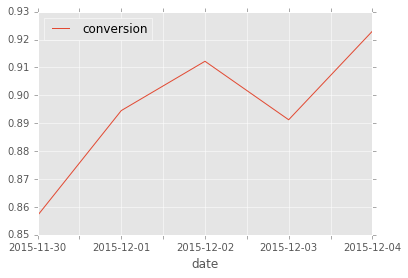

In [9]:
test_conversion_by_day = filter_df[filter_df['test']==1].groupby('date')['conversion'].mean()
control_conversion_by_day = filter_df[filter_df['test']==0].groupby('date')['conversion'].mean()
test_vs_control = test_conversion_by_day/control_conversion_by_day

test_vs_control.reset_index().set_index('date').plot()

***
### Checking Conversion Ratio across all Variables ###
Similarly, we now check the conversion rate ratio along all variables.

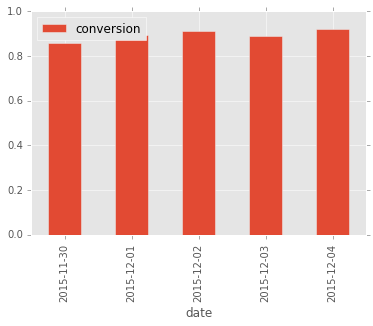

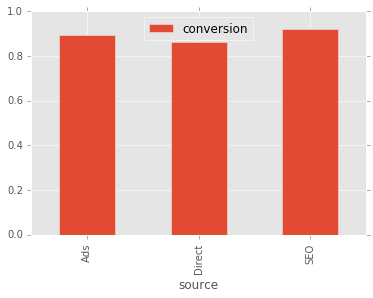

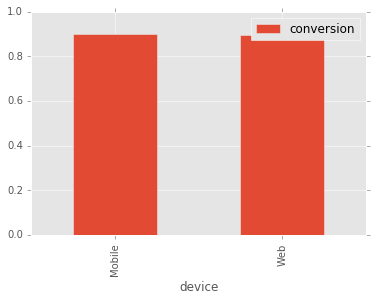

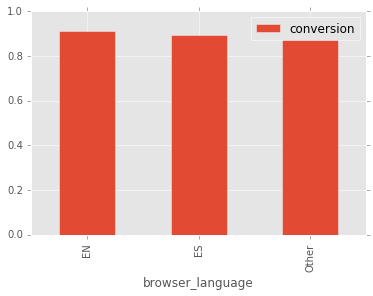

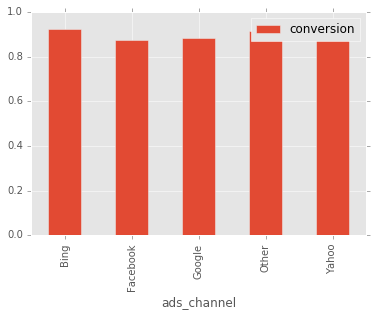

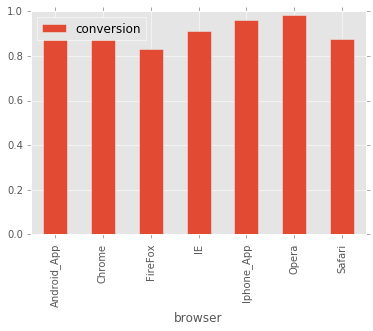

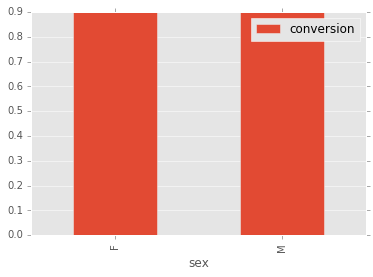

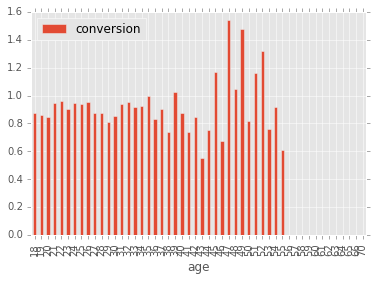

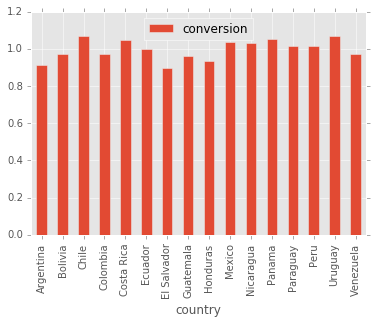

In [10]:
# plot control vs. test side by side
# fig, ax = plt.subplots(figsize=(15, 40))
# cols = list(filter_df.columns)
# n, i = (len(cols) - 1)*2, 0
# for val in cols:
#     if val not in ['user_id','conversion','test']:
#         i += 1
#         plt.subplot(n,1,2*i)
#         filter_df.groupby([val, 'test'])['conversion'].mean().plot(kind='bar')
# plt.show()

# plot test/control
cols = list(filter_df.columns)
for val in cols:
    if val not in ['user_id','conversion','test']:
        test_conversion = filter_df[filter_df['test']==1].groupby(val)['conversion'].mean()
        control_conversion = filter_df[filter_df['test']==0].groupby(val)['conversion'].mean()
        test_vs_control = test_conversion/control_conversion
        test_vs_control.reset_index().set_index(val).plot(kind='bar')

> From the plot, we notice a couple of things:  
1. Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up.
2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better.  

> Time to find out the bias! Likely, there is for some reason some segment of users more likely to end up in test or in control, this segment had a significantly above/below conversion rate and this affected the overall results.  

> In an ideal world, the distribution of people in test and control for each segment should be the same.


Looks like test is consistently worse than control across all variables. The error might be caused by an uneven distribution of users among test and control groups.

***
### Visual Examination of the Split ###
Let's get a visual sense of the split of the data across different categories

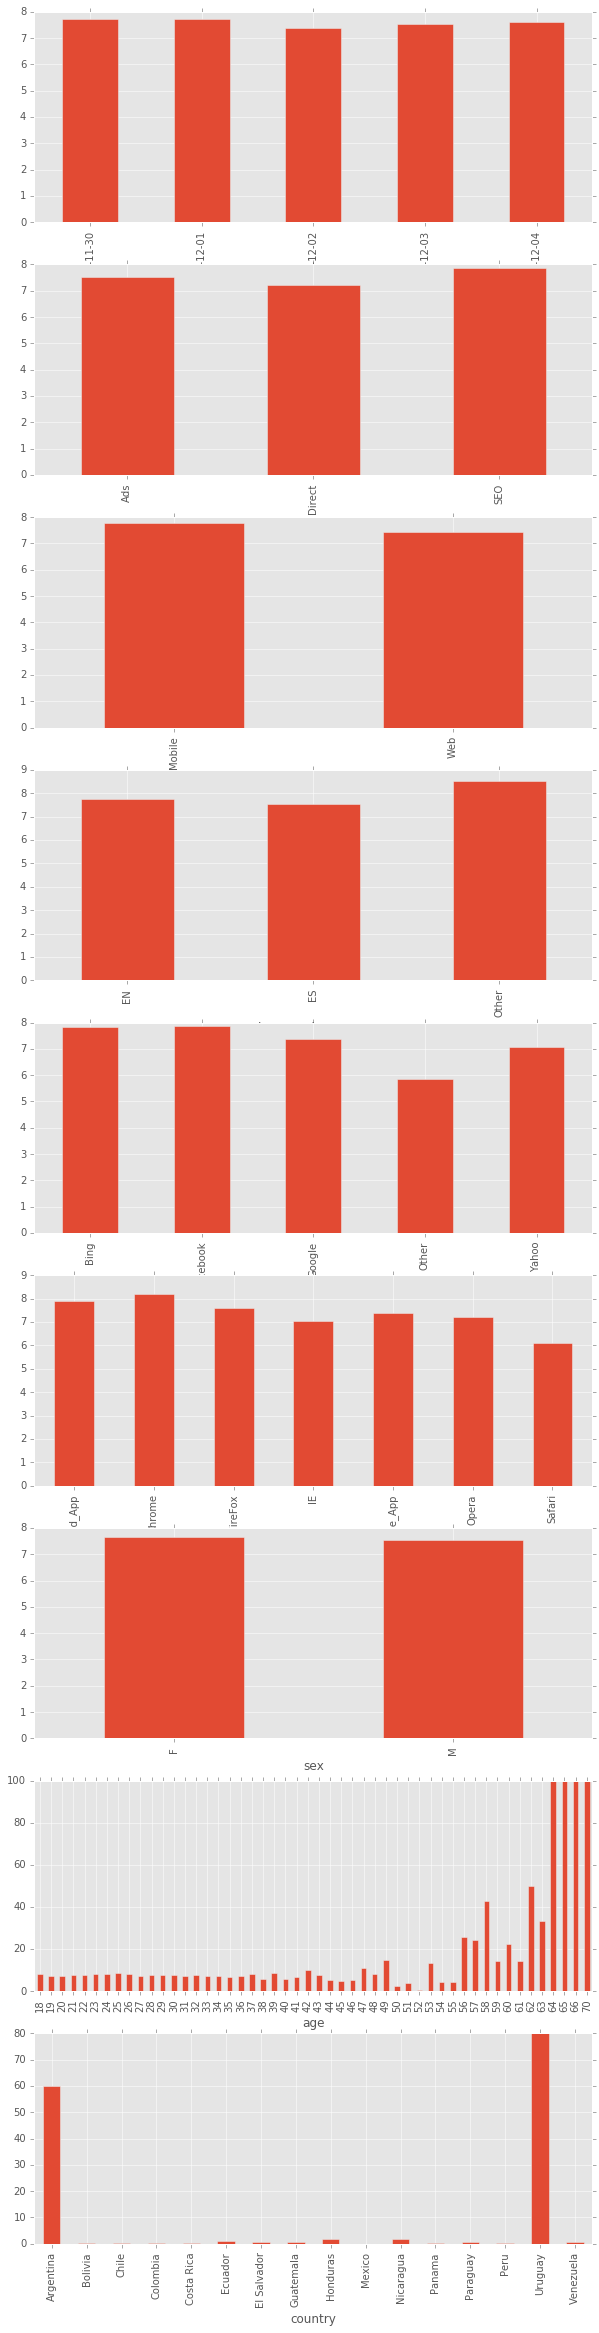

In [11]:
def even_split(df, cat):
    cat_split = pd.crosstab(df[cat], df['test'])
    cat_split['sum'] = cat_split.apply(sum, axis=1)
    cat_split['0 (perc)'] = cat_split[0]/cat_split['sum']*100
    cat_split['1 (perc)'] = cat_split[1]/cat_split['sum']*100
    cat_split['diff'] = abs(cat_split['0 (perc)'] - cat_split['1 (perc)'])
    cat_split['diff'].plot(kind='bar')


cols = list(filter_df.columns)
n, i = len(cols) - 3, 0
fig, ax = plt.subplots(figsize=(10, 40))
for cat in cols:
    if cat not in ['user_id','conversion','test']:
        i += 1
        plt.subplot(n,1,i)
        even_split(filter_df, cat)
plt.show()

***
### Chi-Squared Test on Split ###
We now conduct Chi Squared test to see if any users are unevenly distributed in any of the segments.

In [12]:
def chisquare_test(df, cat):
    actual = df.groupby([cat,'test'])['conversion'].count()
    n = len(actual)
    
    expected_total = df.groupby(cat)['conversion'].count()
    expected = [v*0.5 for v in expected_total for _ in (0,1)]
    
    test_result = [chisquare(actual[2*i: 2*i + 2], f_exp = expected[2*i: 2*i + 2]) for i in range(n//2)]
    test_result = [(expected_total.index[idx], stat, p_value)  for idx, (stat, p_value) in enumerate(test_result)]
    return test_result

In [13]:
columns = ['date', 'source', 'device', 'browser_language', 'ads_channel', 'browser', 'sex', 'country']

for cat in columns:
    print('VARIABLE: ', cat)
    print('{0:15} {1:>20} {2:>20}'.format('name', 'chi2 statistic', 'p value'))
    for name, stat, p_value in chisquare_test(filter_df, cat):
        print('{0:15} {1:20.3f} {2:20.3e}'.format(name, stat, p_value))
    
    print('-'*40)

VARIABLE:  date
name                  chi2 statistic              p value
2015-11-30                   376.262            8.105e-84
2015-12-01                   373.582            3.107e-83
2015-12-02                   341.060            3.749e-76
2015-12-03                   502.807           2.329e-111
2015-12-04                   720.485           1.050e-158
----------------------------------------
VARIABLE:  source
name                  chi2 statistic              p value
Ads                          909.908           6.886e-200
Direct                       420.309            2.091e-93
SEO                          985.646           2.368e-216
----------------------------------------
VARIABLE:  device
name                  chi2 statistic              p value
Mobile                      1082.701           1.900e-237
Web                         1232.180           6.190e-270
----------------------------------------
VARIABLE:  browser_language
name                  chi2 statistic       

Looks like in the country variable, Argentina and Uruguay have an unsually high chi2 values. Let's take a look at the actual counts.

In [14]:
# check diff between test and control conversion rate for each country
# old_means_by_country = filter_df[filter_df['test'] == 0].groupby('country')['conversion'].mean()
# new_means_by_country = filter_df[filter_df['test'] == 1].groupby('country')['conversion'].mean()
# diff = dict(new_means_by_country - old_means_by_country)

# total_user_counts = dict(filter_df['country'].value_counts())

# diff_ls = [(country, diff[country], total_user_counts[country]) for country in diff.keys()]
# sorted(diff_ls, key=lambda x:x[1], reverse=True)

# check the sizes of test and control groups for each country
filter_df.groupby(['country','test'])['conversion'].count()

country      test
Argentina    0        9356
             1       37377
Bolivia      0        5550
             1        5574
Chile        0        9853
             1        9884
Colombia     0       27088
             1       26972
Costa Rica   0        2660
             1        2649
Ecuador      0        8036
             1        7859
El Salvador  0        4108
             1        4067
Guatemala    0        7622
             1        7503
Honduras     0        4361
             1        4207
Mexico       0       64209
             1       64275
Nicaragua    0        3419
             1        3304
Panama       0        1966
             1        1985
Paraguay     0        3650
             1        3697
Peru         0       16869
             1       16797
Uruguay      0         415
             1        3719
Venezuela    0       16149
             1       15905
Name: conversion, dtype: int64

> Argentina and Uruguay together have 80% test and 20% control. 

This might be the reason why we are seeing the worsening result.

***

## Validation ##

> Let’s check the test results after controlling for country. That is, we check for each country how the test is doing.

In [15]:
grouped = filter_df.groupby('country')
for name, group in grouped:
    stat, p_value = ttest_ind(group[group['test'] == 0]['conversion'], 
                              group[group['test'] == 1]['conversion'], 
                              equal_var = False)
    print('{0:15} {1:20.3f} {2:20.3f}'.format(name, stat, p_value))

Argentina                      0.964                0.335
Bolivia                        0.360                0.719
Chile                         -1.030                0.303
Colombia                       0.800                0.424
Costa Rica                    -0.402                0.688
Ecuador                        0.048                0.962
El Salvador                    1.155                0.248
Guatemala                      0.565                0.572
Honduras                       0.720                0.471
Mexico                        -1.387                0.166
Nicaragua                     -0.279                0.780
Panama                        -0.378                0.705
Paraguay                      -0.146                0.884
Peru                          -0.290                0.772
Uruguay                       -0.151                0.880
Venezuela                      0.563                0.574


> After we control for country, the test clearly appears non significant. Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse!

Additionally, let's see if the we adjust the relative size of test/control group for Argentina and Uruguay, we will see a different result for the conversion comparison

In [16]:
new_df = combined_df[~combined_df['country'].isin(['Argentina', 'Spain', 'Uruguay'])]
print('new_df size: ', new_df.shape)

ratio = new_df[new_df['test']==0].shape[0] / new_df[new_df['test']==1].shape[0]
print('ratio: ', ratio)
print()


print('Correction: Argentina')
df_arg_non_test = combined_df[(combined_df['country'] == 'Argentina') & (combined_df['test'] == 0)]
print('Argentina Non Test: ', df_arg_non_test.shape)

df_arg_test = combined_df[(combined_df['country'] == 'Argentina') & (combined_df['test'] == 1)]
print('Argentina Test: ', df_arg_test.shape)

df_arg_test_new = df_arg_test.sample(round(ratio*df_arg_non_test.shape[0]))
print('New Argentina Test: ', df_arg_test_new.shape)
print()


print('Correction: Uruguay')
df_uru_non_test = combined_df[(combined_df['country'] == 'Uruguay') & (combined_df['test'] == 0)]
print('Uruguay Non Test: ', df_uru_non_test.shape)

df_uru_test = combined_df[(combined_df['country'] == 'Uruguay') & (combined_df['test'] == 1)]
print('Uruguay Test: ', df_uru_test.shape)

df_uru_test_new = df_uru_test.sample(round(ratio*df_uru_non_test.shape[0]))
print('New Uruguay Test: ', df_uru_test_new.shape)
print()


new_df2 = pd.concat([new_df, df_arg_non_test, df_arg_test_new, df_uru_non_test, df_uru_test_new])
print('new_df size: ', new_df2.shape)
print('conversion rate by', new_df2.groupby('test')['conversion'].mean())

ttest_ind(new_df2[new_df2['test'] == 0]['conversion'], new_df2[new_df2['test'] == 1]['conversion'], equal_var = False)

new_df size:  (350218, 12)
ratio:  1.0049347943072395

Correction: Argentina
Argentina Non Test:  (9356, 12)
Argentina Test:  (37377, 12)
New Argentina Test:  (9402, 12)

Correction: Uruguay
Uruguay Non Test:  (415, 12)
Uruguay Test:  (3719, 12)
New Uruguay Test:  (417, 12)

new_df size:  (369808, 12)
conversion rate by test
0    0.048292
1    0.048483
Name: conversion, dtype: float64


Ttest_indResult(statistic=-0.27118206615057572, pvalue=0.78625115686532188)

The adjusted conversion rate for test is about the same as that of the control group. What we see confirms our hypothesis that the uneven distribution of users for Argentina and Uruguay leads to the conversion drop we saw earlier.